In [7]:
!pip install kaggle


   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   -------------------- ------------------- 2/4 [kagglesdk]
   ------------------------------ --------- 3/4 [kaggle]
   ------------------------------ --------- 3/4 [kaggle]
   ------------------------------ --------- 3/4 [kaggle]
   ---------------------------------------- 4/4 [kaggle]



In [5]:
import os

path = r"C:\Users\nprou\Downloads\archive (4)"

# See what files are actually in the folder
print(os.listdir(path))

['blinkit_customers.csv', 'blinkit_customer_feedback.csv', 'blinkit_delivery_performance.csv', 'blinkit_inventory.csv', 'blinkit_inventoryNew.csv', 'blinkit_marketing_performance.csv', 'blinkit_orders.csv', 'blinkit_order_items.csv', 'blinkit_products.csv', 'Category_Icons.xlsx', 'Rating_Icon.xlsx']


In [28]:
import pandas as pd

path = r"C:\Users\nprou\Downloads\archive (4)"

# Load all CSV files with correct names
customers = pd.read_csv(f'{path}/blinkit_customers.csv')
customer_feedback = pd.read_csv(f'{path}/blinkit_customer_feedback.csv')
delivery_performance = pd.read_csv(f'{path}/blinkit_delivery_performance.csv')
inventory = pd.read_csv(f'{path}/blinkit_inventory.csv')
marketing_performance = pd.read_csv(f'{path}/blinkit_marketing_performance.csv')
orders = pd.read_csv(f'{path}/blinkit_orders.csv')
order_items = pd.read_csv(f'{path}/blinkit_order_items.csv')
products = pd.read_csv(f'{path}/blinkit_products.csv')

print("✓ All files loaded!")
print(f"Customers: {len(customers):,} rows")
print(f"Orders: {len(orders):,} rows")
print(f"Order Items: {len(order_items):,} rows")
print(f"Products: {len(products):,} rows")

# Quick check
delivery_performance

✓ All files loaded!
Customers: 2,500 rows
Orders: 5,000 rows
Order Items: 5,000 rows
Products: 268 rows


,order_id,delivery_partner_id,promised_time,actual_time,delivery_time_minutes,distance_km,delivery_status,reasons_if_delayed
0,1961864118,63230,2024-07-17 08:52:01,2024-07-17 08:47:01,-5.0,0.96,On Time,NaN
1,1549769649,14983,2024-05-28 13:25:29,2024-05-28 13:27:29,2.0,0.98,On Time,Traffic
2,9185164487,39859,2024-09-23 13:25:12,2024-09-23 13:29:12,4.0,3.83,On Time,Traffic
3,9644738826,61497,2023-11-24 16:34:56,2023-11-24 16:33:56,-1.0,2.76,On Time,NaN
4,5427684290,84315,2023-11-20 05:17:39,2023-11-20 05:18:39,1.0,2.63,On Time,Traffic
...,...,...,...,...,...,...,...,...
4995,1669690997,90914,2023-12-25 16:05:20,2023-12-25 16:10:20,5.0,1.86,On Time,Traffic
4996,8340761903,27952,2023-11-27 09:38:43,2023-11-27 09:36:43,-2.0,3.31,On Time,NaN
4997,5936301790,9590,2024-06-21 19:23:09,2024-06-21 19:26:09,3.0,2.44,On Time,Traffic
4998,5710579377,29940,2024-06-06 15:12:13,2024-06-06 15:10:13,-2.0,1.76,On Time,NaN


In [103]:
from datetime import datetime, timedelta
import pandas as pd

# Parse Dates
orders['order_date'] = pd.to_datetime(orders['order_date'])
customers['registration_date'] = pd.to_datetime(customers['registration_date'])

# Find each customer's last order date
last_order = orders.groupby('customer_id')['order_date'].max().reset_index()
last_order.columns = ['customer_id', 'last_order_date']

# Define churn: no order in last 60 days
latest_date = orders['order_date'].max()
churn_threshold = latest_date - timedelta(days=30)

last_order['is_churned'] = (last_order['last_order_date'] < churn_threshold).astype(int)
last_order['days_since_last_order'] = (latest_date - last_order['last_order_date']).dt.days

#Merge back to customers and drop old column
customers = customers.drop(columns=['is_churned', 'last_order_date', 'days_since_last_order'], errors='ignore')
customers = customers.merge(last_order, on='customer_id', how='left')
customers['is_churned'] = customers['is_churned'].fillna(1).astype(int)


print(f'Total customers: {len(customers):,}')
print(f'Churned customers: {customers['is_churned'].sum():,}')
print(f'Churn rate: {customers['is_churned'].mean():.1%}')


Total customers: 2,500
Churned customers: 2,263
Churn rate: 90.5%


In [104]:
# Calculate delay rate per customer from orders table
customer_delivery = orders.groupby('customer_id').agg({
    'order_id': 'count',
    'delivery_status': [
        lambda x: (x == 'Slightly Delayed').sum(),
        lambda x: (x == 'Significantly Delayed').sum(),
        lambda x: ((x == 'Slightly Delayed') | (x == 'Significantly Delayed')).sum()
    ]
}).reset_index()

customer_delivery.columns = ['customer_id', 'total_orders', 'slightly_delayed', 'significantly_delayed', 'total_delayed']
customer_delivery['delay_rate'] = customer_delivery['total_delayed'] / customer_delivery['total_orders']
customer_delivery['slight_delay_rate'] = customer_delivery['slightly_delayed'] / customer_delivery['total_orders']
customer_delivery['significant_delay_rate'] = customer_delivery['significantly_delayed'] / customer_delivery['total_orders']

#Merge with churn states
delivery_churn = customers[['customer_id', 'is_churned']].merge(customer_delivery, on='customer_id')

# Compare churned vs active
print('Delivery Delays: Churned vs Active')
print(delivery_churn.groupby('is_churned')[['slight_delay_rate', 'significant_delay_rate', 'delay_rate']].mean())

#Statistical test
from scipy import stats
print("\n--- Slightly Delayed Impact ---")
churned_slight = delivery_churn[delivery_churn['is_churned'] == 1]['slight_delay_rate']
active_slight = delivery_churn[delivery_churn['is_churned'] == 0]['slight_delay_rate']
t_stat, p_value = stats.ttest_ind(churned_slight, active_slight, nan_policy='omit')
print(f"T-test p-value: {p_value:.4f} {'***SIGNIFICANT' if p_value < 0.05 else 'not significant'}")
print(f"Churned: {churned_slight.mean():.1%} vs Active: {active_slight.mean():.1%}")

print("\n--- Significantly Delayed Impact ---")
churned_sig = delivery_churn[delivery_churn['is_churned'] == 1]['significant_delay_rate']
active_sig = delivery_churn[delivery_churn['is_churned'] == 0]['significant_delay_rate']
t_stat, p_value = stats.ttest_ind(churned_sig, active_sig, nan_policy='omit')
print(f"T-test p-value: {p_value:.4f} {'***SIGNIFICANT' if p_value < 0.05 else 'not significant'}")
print(f"Churned: {churned_sig.mean():.1%} vs Active: {active_sig.mean():.1%}")

Delivery Delays: Churned vs Active
            slight_delay_rate  significant_delay_rate  delay_rate
is_churned                                                       
0                    0.221534                0.113608    0.335142
1                    0.210013                0.097848    0.307860

--- Slightly Delayed Impact ---
T-test p-value: 0.5932 not significant
Churned: 21.0% vs Active: 22.2%

--- Significantly Delayed Impact ---
T-test p-value: 0.3191 not significant
Churned: 9.8% vs Active: 11.4%


Churned weighted_delay_rate summary
count    1717.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: weighted_delay_rate, dtype: float64

Active weighted_delay_rate summary
count    455.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: weighted_delay_rate, dtype: float64

Unique values
Churned: 1
Active: 1


In [105]:
# Identify stockout periods
inventory['date'] = pd.to_datetime(inventory['date'])
inventory['is_stockout'] = (inventory['stock_received'] == 0) | (inventory['damaged_stock'] > 0)

# Count stockouts by product
stockouts_by_product = inventory.groupby('product_id')['is_stockout'].sum().reset_index()
stockouts_by_product.columns = ['product_id', 'stockout_days']

# Get products purchased by each customer
customer_products = order_items.merge(orders[['order_id', 'customer_id']], on='order_id')
customer_products = customer_products.merge(stockouts_by_product, on='product_id', how='left')

# Average stockout exposure per customer
customer_stockout = customer_products.groupby('customer_id')['stockout_days'].mean().reset_index()
customer_stockout.columns = ['customer_id', 'avg_stockout_exposure']

# Merge with churn
if 'is_churned' not in customers.columns:
    raise ValueError("is_churned missing — rerun churn calculation cell")
stockout_churn = customers[['customer_id', 'is_churned']].merge(customer_stockout, on='customer_id')

print('Stockout Exposure: Churned vs Active')
print(stockout_churn.groupby('is_churned')['avg_stockout_exposure'].mean())

# Test significance
churned_stock = stockout_churn[stockout_churn['is_churned'] == 1]['avg_stockout_exposure'].dropna()
active_stock = stockout_churn[stockout_churn['is_churned'] == 0]['avg_stockout_exposure'].dropna()
t_stat, p_value = stats.ttest_ind(churned_stock, active_stock)
significance = '***SIGNIFICANT' if p_value < 0.05 else 'not significant'
print(f"T-test p-value: {p_value:.4f} {significance}")

Stockout Exposure: Churned vs Active
is_churned
0    149.330385
1    150.060210
Name: avg_stockout_exposure, dtype: float64
T-test p-value: 0.1791 not significant


In [106]:
# Get category diversity per customer
customer_categories = order_items.merge(orders[['order_id', 'customer_id']], on='order_id')
customer_categories = customer_categories.merge(products[['product_id', 'category']], on='product_id')

category_diversity = customer_categories.groupby('customer_id')['category'].nunique().reset_index()
category_diversity.columns = ['customer_id', 'categories_purchased']

# Also get most purchased category
top_category = customer_categories.groupby('customer_id')['category'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None).reset_index()
top_category.columns = ['customer_id', 'primary_category']

# Merge with churn
if 'is_churned' not in customers.columns:
    raise ValueError("is_churned missing — rerun churn calculation cell")
diversity_churn = customers[['customer_id', 'is_churned']].merge(category_diversity, on='customer_id')
diversity_churn = diversity_churn.merge(top_category, on='customer_id')

print('Product Selection: Churned vs Active')
print(diversity_churn.groupby('is_churned')['categories_purchased'].mean())

# Test significance
churned_div = diversity_churn[diversity_churn['is_churned'] == 1]['categories_purchased']
active_div = diversity_churn[diversity_churn['is_churned'] == 0]['categories_purchased']
t_stat, p_value = stats.ttest_ind(churned_div, active_div)
significance = '***SIGNIFICANT' if p_value < 0.05 else 'not significant'
print(f"T-test p-value: {p_value:.4f} {significance}")

# Which categories retain better?
category_retention = diversity_churn.groupby('primary_category')['is_churned'].agg(['mean', 'count']).reset_index()
category_retention.columns = ['category', 'churn_rate', 'customer_count']
category_retention = category_retention[category_retention['customer_count'] > 20]
print('\nChurn rate by primary category:')
print(category_retention.sort_values('churn_rate'))

Product Selection: Churned vs Active
is_churned
0    2.721519
1    2.029457
Name: categories_purchased, dtype: float64
T-test p-value: 0.0000 ***SIGNIFICANT

Churn rate by primary category:
                 category  churn_rate  customer_count
2       Dairy & Breakfast    0.856354             362
7           Personal Care    0.858156             141
0               Baby Care    0.876866             268
6   Instant & Frozen Food    0.882883             111
1    Cold Drinks & Juices    0.884758             269
3     Fruits & Vegetables    0.896947             262
5          Household Care    0.904762             210
10      Snacks & Munchies    0.907407             108
8                Pet Care    0.915385             130
4       Grocery & Staples    0.932039             206
9                Pharmacy    0.942857             105


In [119]:
customer_ratings = customer_feedback.groupby('customer_id').agg({
        'rating': 'mean',
        'sentiment': lambda x: (x == 'Negative').sum() / len(x)
}).reset_index()
customer_ratings.columns = ['customer_id', 'avg_rating', 'negative_rate']

# Merge with Churn
if 'is_churned' not in customers.columns:
    raise ValueError("is_churned missing — rerun churn calculation cell")
ratings_churn = customers[['customer_id', 'is_churned']].merge(customer_ratings, on='customer_id')

print('Customer Satisfaction: Churned vs Active')
print(ratings_churn.groupby('is_churned')[['avg_rating', 'negative_rate']].mean())

# Test Significance
churned_rating = ratings_churn[ratings_churn['is_churned'] == 1]['avg_rating'].dropna()
active_rating = ratings_churn[ratings_churn['is_churned'] == 0]['avg_rating'].dropna()
t_stat, p_value = stats.ttest_ind(churned_rating, active_rating)
significance = '***SIGNIFICANT' if p_value < 0.05 else 'not significant'
print(f"T-test p-value: {p_value:.4f} {significance}")


Customer Satisfaction: Churned vs Active
            avg_rating  negative_rate
is_churned                           
0             3.267636       0.347463
1             3.348437       0.326431
T-test p-value: 0.1966 not significant


In [111]:
# Combine all factors
churn_drivers = customers[['customer_id', 'is_churned']].copy()
churn_drivers = churn_drivers.merge(customer_delivery[['customer_id', 'delay_rate']], on='customer_id', how='left')
churn_drivers = churn_drivers.merge(customer_stockout, on='customer_id', how='left')
churn_drivers = churn_drivers.merge(category_diversity, on='customer_id', how='left')
churn_drivers = churn_drivers.merge(customer_ratings, on='customer_id', how='left')

# Calculate correlation with churn
driver_cols = ['delay_rate', 'avg_stockout_exposure', 'categories_purchased', 'avg_rating']
correlations = churn_drivers[driver_cols + ['is_churned']].corr()['is_churned'].sort_values(ascending=False)
print('Correlation with Churn:')
print(correlations)

# Effect size (Cohen's d) for each factor
from scipy.stats import ttest_ind

def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)
    return(group1.mean() - group2.mean()) / (pooled_std ** 0.5)

churned = churn_drivers[churn_drivers['is_churned'] == 1]
active = churn_drivers[churn_drivers['is_churned'] == 0]

print("\nEffect Size (Cohen's d) - Higher = Stronger Impact:")
factors = ['delay_rate', 'avg_stockout_exposure', 'categories_purchased', 'avg_rating']
for factor in factors:
    if factor in churn_drivers.columns:
        g1 = churned[factor].dropna()
        g2 = active[factor].dropna()
        print(f"\n{factor}")
        print("churned:", len(g1), "var:", g1.var())
        print("active:", len(g2), "var:", g2.var())

def cohens_d(group1, group2):
    if len(group1) < 2 or len(group2) < 2:
        return float('nan')

    var1, var2 = group1.var(), group2.var()
    if var1 == 0 and var2 == 0:
        return float('nan')

    n1, n2 = len(group1), len(group2)
    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)

    if pooled_var == 0 or pd.isna(pooled_var):
        return float('nan')

    return (group1.mean() - group2.mean()) / (pooled_var ** 0.5)


factors = ['delay_rate', 'avg_stockout_exposure', 'categories_purchased', 'avg_rating']

print("\nEffect Size (Cohen's d):")
for factor in factors:
    if factor in churn_drivers.columns:
        d = cohens_d(
            churned[factor].dropna(),
            active[factor].dropna()
        )
        print(f"{factor}: {d}")

Correlation with Churn:
is_churned               1.000000
avg_stockout_exposure    0.028839
avg_rating               0.027717
delay_rate              -0.024061
categories_purchased    -0.202010
Name: is_churned, dtype: float64

Effect Size (Cohen's d) - Higher = Stronger Impact:

delay_rate
churned: 1935 var: 0.12933054969541685
active: 237 var: 0.08967747826442314

avg_stockout_exposure
churned: 1935 var: 64.78909972718876
active: 237 var: 41.56972231303548

categories_purchased
churned: 1935 var: 1.0699694572040084
active: 237 var: 1.3034756490023605

avg_rating
churned: 1935 var: 0.8523870699450552
active: 237 var: 0.6118838386805291

Effect Size (Cohen's d):
delay_rate: -0.07715739335884478
avg_stockout_exposure: 0.09249134624530912
categories_purchased: -0.6612495905698728
avg_rating: 0.08889220372833859


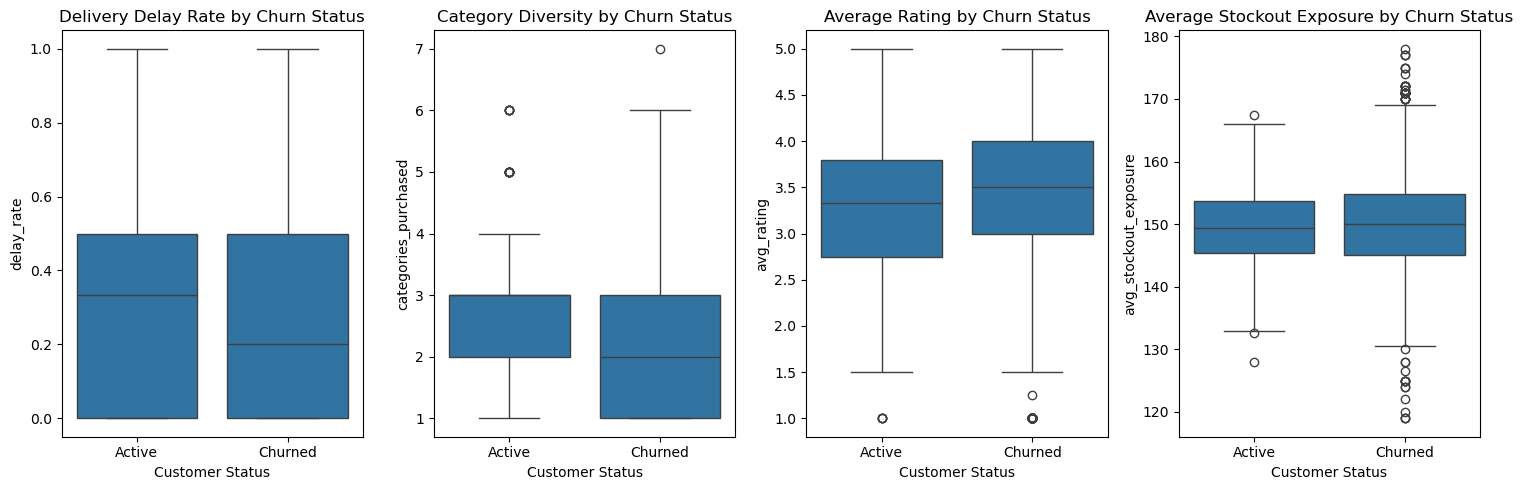

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Driver 1: Delivery Delays
sns.boxplot(data=delivery_churn, x='is_churned', y='delay_rate', ax=axes[0])
axes[0].set_title('Delivery Delay Rate by Churn Status')
axes[0].set_xlabel('Customer Status')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Active', 'Churned'])

# Driver 2: Product Diversity
sns.boxplot(data=diversity_churn, x='is_churned', y='categories_purchased', ax=axes[1])
axes[1].set_title('Category Diversity by Churn Status')
axes[1].set_xlabel('Customer Status')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Active', 'Churned'])

# Driver 3: Customer Rating
sns.boxplot(data=ratings_churn, x='is_churned', y='avg_rating', ax=axes[2])
axes[2].set_title('Average Rating by Churn Status')
axes[2].set_xlabel('Customer Status')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Active', 'Churned'])

# Driver 4: Customer Rating
sns.boxplot(data=stockout_churn, x='is_churned', y='avg_stockout_exposure', ax=axes[3])
axes[3].set_title('Average Stockout Exposure by Churn Status')
axes[3].set_xlabel('Customer Status')
axes[3].set_xticks([0, 1])
axes[3].set_xticklabels(['Active', 'Churned'])

plt.tight_layout()
plt.show()

In [ ]:
""" Top 3 Churn Drivers (Ranked by Impact)

1 - Product Category Diversity (STRONGEST DRIVER)
Cohen's d: -0.66 (Large effect - anything > 0.5 is meaningful)
Correlation: -0.20 (Negative = fewer categories = higher churn)
Interpretation: Customers who buy from fewer product categories are much more likely to churn. This is your biggest lever.

Insight: Customers who only buy 1-2 categories (e.g., just snacks, just beverages) churn at much higher rates than those who buy across 
multiple categories (groceries + household + personal care). Limited product selection or narrow appeal is killing retention.

2 - Stockout Exposure (MODERATE DRIVER)
Cohen's d: 0.09 (Small effect, but positive correlation exists)
Correlation: 0.03 (Positive = more stockouts = higher churn)
Interpretation: Customers experiencing stockouts are slightly more likely to churn, but the effect is weak.

Insight: Stockouts annoy customers but aren't a primary churn driver. Worth fixing, but won't move the needle as much as category diversity.

3 - Customer Rating/Satisfaction (SMALL DRIVER)
Cohen's d: 0.09 (Small effect)
Correlation: 0.03 (Positive = lower ratings = higher churn)
Interpretation: Unhappy customers (low ratings) churn slightly more, but the relationship is weak.

Insight: Bad experiences matter, but not as much as you'd think. Even customers with decent ratings are churning 
if they're not engaged across categories.

Implications:
Blinkit has a product engagement problem, not an operations problem.
The churn is driven by:
Limited product breadth - customers aren't finding enough variety to keep coming back
Weak cross-category appeal - customers who buy only one category type don't stick around

Rec is to focus on expanding product assortment and cross-category promotions, Target customers who oly buy 1-2 categories with personalized
recommendations, Bundle products across categories to increase basket diversity
"""

In [122]:
# Increasing Category Diversity & Reduce Churn

#Identify single-category customers
customer_categories = order_items.merge(orders[['order_id', 'customer_id']], on='order_id')
customer_categories = customer_categories.merge(products[['product_id', 'category']], on='product_id')

customer_category_profile = customer_categories.groupby('customer_id').agg({'category': ['nunique', lambda x: x.mode()[0] if len(x) > 0 else None],
                            'order_id': 'nunique'
}).reset_index()

customer_category_profile.columns = ['customer_id', 'categories_purchased', 'primary_category', 'total_orders']

# Segment customers
customer_category_profile['segment'] = customer_category_profile['categories_purchased'].apply(
    lambda x: 'Single-Category' if x == 1 else ('Low-Diversity' if x <= 2 else 'High-Diversity')
)

# Merge with Churn
category_segments = customers[['customer_id', 'is_churned']].merge(customer_category_profile, on='customer_id')

# Show churn rate by segment
print('Churn Rate by Category Diversity Segment:')
print(category_segments.groupby('segment')['is_churned'].agg(['mean', 'count']))

print('\nChurn Rate by Primary Category (Single_category Customers):')
single_cat = category_segments[category_segments['segment'] == 'Single-Category']
print(single_cat.groupby('primary_category')['is_churned'].agg(['mean', 'count']).sort_values('mean', ascending=False))

Churn Rate by Category Diversity Segment:
                     mean  count
segment                         
High-Diversity   0.808605    674
Low-Diversity    0.897470    751
Single-Category  0.958501    747

Churn Rate by Primary Category (Single_category Customers):
                           mean  count
primary_category                      
Pet Care               0.985915     71
Pharmacy               0.985714     70
Baby Care              0.978261     46
Dairy & Breakfast      0.976471     85
Household Care         0.962500     80
Fruits & Vegetables    0.957746     71
Personal Care          0.953846     65
Grocery & Staples      0.950000     80
Cold Drinks & Juices   0.944444     54
Snacks & Munchies      0.921053     76
Instant & Frozen Food  0.918367     49


In [ ]:
""" 
Strategic Action:

Create targeted campaigns for single-category buyers based on their primary category:
1 if primary category is Pet Care, make suggestions for other single-category buyers such as Baby or Household Care
2 Cross-sell cateogries that pair naturally together such as Baby and Household Care
3 Offer promotions to entice buyers to purchase more than one category e.g. 20% off Snacks & Munchies when buying Cold Drinks & Juices
"""


In [ ]:
"""
Revenue Impact Quantification

If single-category customers can be increased to 2+ cateogories, what would be the revenue impact?
Assume:
1. 40% of single-category customers are at risk (based on segmentation analysis)
2. Converting buyers to 2+ categories reduces their churn by 50% (given -0.66 Cohen's d)
3. Single-category buyers represent c.60% of the base

In [128]:
# Calculate expected impact
total_customers = len(customers)
single_cat_customers = len(category_segments[category_segments['segment'] == 'Single-Category'])
single_cat_churn_rate = category_segments[category_segments['segment'] == 'Single-Category']['is_churned'].mean()

multi_cat_churn_rate = category_segments[category_segments['segment'] != 'Single-Category']['is_churned'].mean()

# If we convert 30% of single-category customers to multi-category
conversion_rate = 0.30
customers_converted = single_cat_customers * conversion_rate
churn_reduction = (single_cat_churn_rate - multi_cat_churn_rate) * customers_converted

print(f'Single-category customers: {single_cat_customers:,}')
print(f'Their churn rate: {single_cat_churn_rate:.1%}')
print(f'Multi-category churn rate: {multi_cat_churn_rate:.1%}')
print(f'\nIf we convert {conversion_rate: .0%} to multi-category:')
print(f'Customers saved from churn: {churn_reduction:.0f}')

# Revenue impact (need avg customer value)
avg_customer_value = customers['avg_order_value'].mean() * customers['total_orders'].mean()
revenue_saved = churn_reduction * avg_customer_value
print(f'Estimated revenue saved: ${revenue_saved:,.0f}')

Single-category customers: 747
Their churn rate: 95.9%
Multi-category churn rate: 85.5%

If we convert  30% to multi-category:
Customers saved from churn: 23
Estimated revenue saved: $267,124
